### aim: 

### date: 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

In [4]:
import glob
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/MO_pipeline/')
import scendict as sc
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/MODPROC_ROBOT/MultiModelMonitor/WORK_SCRIPTS')
import breakdown as bp
import numpy as np


def get_sanity(tr, baseDir, startyear = -99,\
               sdir = '/gpfs/home/mep22dku/scratch/SOZONE/MODPROC_ROBOT/MultiModelMonitor/OUTPUT/'):
    
    fact = 0.5
    fig, axs = plt.subplots(3,2, figsize=(20*fact, 14*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    #case where we want to get rid of spinup years
    if startyear < 0:
        tmin, tmax = bp.max_min_yrs(tr, baseDir)
    if startyear > 0:
        tmin, tmax = bp.max_min_yrs(tr, baseDir)
        tmin = startyear
    print(f'making sanity for run {tr}: {tmin}-{tmax}')
    
    t_yearlist = bp.make_yearlist(tmin,tmax,'ptrc',tr, baseDir)
    tds_ptrc = xr.open_mfdataset(t_yearlist, chunks={'time_counter': 120})
    t_yearlist = bp.make_yearlist(tmin,tmax,'diad',tr, baseDir)
    tds_diad = xr.open_mfdataset(t_yearlist, chunks={'time_counter': 120})
    
    t_dsets = [tds_ptrc, tds_ptrc, tds_diad, tds_diad, tds_diad]
    t_vars = ['GOC', 'POC', 'EXP', 'PPT', 'TChl']
    
    td = tds_ptrc.indexes['time_counter'].to_datetimeindex()
    
    for x in range(0,5):
        tds = t_dsets[x]; tvar = t_vars[x]
        print(tvar)
        yrs = tds[tvar].shape[0]/12

        gocmean = np.zeros(int(yrs)*12)
        gocmax = np.zeros(int(yrs)*12)
        ind = 0
        for i in range(0,int(yrs)):
            if i%30 == 0:
                print(i)
            goc = tds[tvar][ind:ind+12,:,:,:].values
            goc[goc == 0] = np.nan
            w = np.nanmean(np.nanmean(np.nanmean(goc, axis = 3), axis =2), axis =1)
            gocmean[ind:ind+12] = (w)
            w = np.nanmax(np.nanmax(np.nanmax(goc, axis = 3), axis =2), axis =1)
            gocmax[ind:ind+12] = (w)
            ind = ind+12
            
        axs[x].plot(td,gocmean, label = 'mean (NOT VOLUME WEIGHTED \n JUST SIMPLE MEAN OF ARRAY)')
        axs[x].plot(td,gocmax, label = 'max')
        axs[x].set_yscale('log')
        axs[x].set_title(tvar)
        
        axs[0].legend(loc = 'best', fontsize = 10)
    fig.suptitle(f'{tr} (blue mean value, orange max value)')
    plt.tight_layout()
    plt.show()
    fig.savefig(f'{sdir}/SANITYCHECK_{tr}_{tmin}-{tmax}.png')

In [5]:
tr = 'RIV12_PT_ER17'
#
tr = 'TOM12_RW_GRO2'
baseDir = '/gpfs/afm/greenocean/software/runs/'
startyear = 1948; 

#case where we want to get rid of spinup years
if startyear < 0:
    tmin, tmax = bp.max_min_yrs(tr, baseDir)
if startyear > 0:
    tmin, tmax = bp.max_min_yrs(tr, baseDir)
    tmin = startyear
print(f'making sanity for run {tr}: {tmin}-{tmax}')


t_yearlist = bp.make_yearlist(tmin,tmax,'ptrc',tr, baseDir)
tds_ptrc = xr.open_mfdataset(t_yearlist, chunks={'time_counter': 120})

t_yearlist = bp.make_yearlist(tmin,tmax,'diad',tr, baseDir)
tds_diad = xr.open_mfdataset(t_yearlist, chunks={'time_counter': 120})

# tds_ptrc.load()
# tds_diad.load()

t_dsets = [tds_ptrc, tds_ptrc, tds_diad, tds_diad, tds_diad]
t_vars = ['GOC', 'POC', 'EXP', 'PPT', 'TChl']

td = tds_ptrc.indexes['time_counter'].to_datetimeindex()
#bs.get_sanity(tr, baseDir, startyear = 1948, sdir = '/gpfs/home/mep22dku/scratch/SOZONE/MODPROC_ROBOT/MultiModelMonitor/OUTPUT/')

making sanity for run TOM12_RW_GRO2: 1948-2021


In [6]:
tommesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tommesh
tommesh['area'] = tommesh.tmask[0,0,:,:] * tommesh.e1t[0,:,:] * tommesh.e2t[0,:,:] 
tommesh['volume'] = tommesh.tmask[0,:,:,:] * tommesh.e1t[:,:,:]*tommesh.e2t[:,:,:] * tommesh.e3t_0[:,:,:]
tommesh['volume']
tommesh = tommesh.rename({'z': 'deptht'})

#print(tommesh['volume'])

#print(tommesh['volume'])
#plt.pcolormesh(tommesh['volume'][28,:,:,0])

# tds_gocuw = tds_ptrc['GOC'].values
# tds_gocuw[tds_gocuw == 0] = np.nan
# gocuw_fd = np.nanmean(np.nanmean(np.nanmean(goc, axis = 3), axis =2), axis =1)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


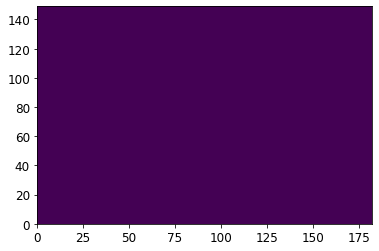

In [7]:
plt.pcolormesh(tommesh.tmask[0,30,:,:])

(888, 149, 182)


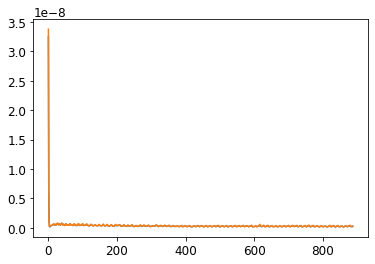

In [8]:
td = 29
tds = tommesh.tmask.isel(deptht=td) * tommesh.e1t[0,:,:] * tommesh.e2t[0,:,:] 

tds_gocw = tds_ptrc['GOC'].isel(deptht = td).weighted(tds).mean(dim = ['y', 'x'])
tds_gocw22 = tds_ptrc['GOC'].isel(deptht = td).values
print(np.shape(tds_gocw22))
tds_gocw22[tds_gocw22 == 0] = np.nan
tds_gocw2 = np.nanmean(np.nanmean(tds_gocw22,axis = 2),axis =1)

plt.figure()
plt.plot(tds_gocw)
plt.plot(tds_gocw2)
#plt.pcolormesh(tds[0,:,:].values)

In [9]:
tds_ptrc['GOC']

<xarray.DataArray 'GOC' (time_counter: 888, deptht: 31, y: 149, x: 182)>
dask.array<concatenate, shape=(888, 31, 149, 182), dtype=float32, chunksize=(12, 31, 149, 182), chunktype=numpy.ndarray>
Coordinates:
    nav_lat        (y, x) float32 dask.array<chunksize=(149, 182), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(149, 182), meta=np.ndarray>
  * deptht         (deptht) float32 4.999938 15.000288 ... 4749.913 5250.2266
    time_centered  (time_counter) object dask.array<chunksize=(12,), meta=np.ndarray>
  * time_counter   (time_counter) object 1948-01-16 12:00:00 ... 2021-12-16 1...
Dimensions without coordinates: y, x
Attributes:
    long_name:           big Particulate organic carbon Concentr.
    units:               mol/L
    online_operation:    average
    interval_operation:  5760 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 5760 s)

In [10]:
tds_ptrc['GOC']

tds_gocw = tds_ptrc['GOC'].weighted(tommesh['volume']).mean(dim = ['y', 'x'])
tds_gocwfd = tds_ptrc['GOC'].weighted(tommesh['volume']).mean(dim = ['y', 'x','deptht'])
tds_gocuw = tds_ptrc['GOC'].mean(dim = ['y', 'x'])
tds_gocuwfd = tds_ptrc['GOC'].mean(dim = ['y', 'x','deptht'])

In [11]:
tval = tds_gocw.values
tval2 = tds_gocuw.values
tval3 = tds_gocuwfd.values
tval4 = tds_gocwfd.values

In [12]:
print(tds_ptrc['deptht'][0])
print(tds_ptrc['deptht'][10])

<xarray.DataArray 'deptht' ()>
array(4.999938, dtype=float32)
Coordinates:
    deptht   float32 4.999938
Attributes:
    long_name:  Vertical T levels
    units:      m
    axis:       Z
    positive:   down
    bounds:     deptht_bounds
<xarray.DataArray 'deptht' ()>
array(105.96992, dtype=float32)
Coordinates:
    deptht   float32 105.96992
Attributes:
    long_name:  Vertical T levels
    units:      m
    axis:       Z
    positive:   down
    bounds:     deptht_bounds


In [13]:
td = tds_ptrc.indexes['time_counter'].to_datetimeindex()

Text(0.5, 0.98, 'GOC in TOM12_RW_GRO2, by-layer means weighted (left) and unweighted (right)')

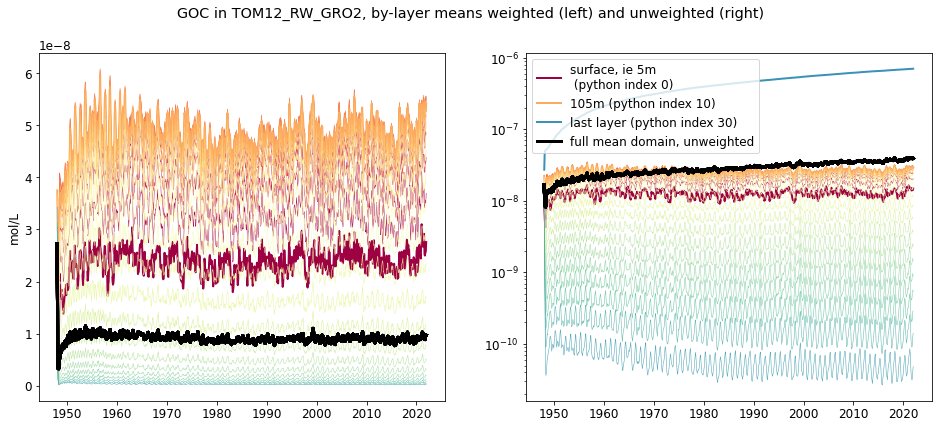

In [18]:
tcm = plt.cm.get_cmap('Spectral') #Spectral #cm.phase
fact = 0.8
fig, axs = plt.subplots(1,2, figsize=(20*fact, 8*fact), facecolor='w', edgecolor='k')


for i in range(0,31):
    axs[0].plot(td,tval[:,i,0], linestyle = '-', color = tcm(1.*(i)/34), linewidth = 0.5)
    axs[1].plot(td,tval2[:,i], linestyle = '-', color = tcm(1.*(i)/34), linewidth = 0.5)
    axs[1].plot(td,tval3, linestyle = '-', color ='k', linewidth = 3)
    axs[0].plot(td,tval4, linestyle = '-', color ='k', linewidth = 3)
    axs[1].set_yscale('log')
    
    if i == 0:
        axs[0].plot(td,tval[:,i,0], linestyle = '-', color = tcm(1.*(i)/34), linewidth = 2, label = 'surface, ie 5m \n (python index 0)')
        axs[1].plot(td,tval2[:,i], linestyle = '-', color = tcm(1.*(i)/34), linewidth = 2, label = 'surface, ie 5m \n (python index 0)')
        axs[1].plot(td,tval3, linestyle = '-', color ='k', linewidth = 3)

        
    if i == 10:
        axs[0].plot(td,tval[:,i,0], linestyle = '-', color = tcm(1.*(i)/34), linewidth = 2, label = '105m (python index 10)')
        axs[1].plot(td,tval2[:,i], linestyle = '-', color = tcm(1.*(i)/34), linewidth = 2, label = '105m (python index 10)')
        axs[1].plot(td,tval3, linestyle = '-', color ='k', linewidth = 3)

    
    if i == 30:
        axs[0].plot(td,tval[:,i,0], linestyle = '-', color = tcm(1.*(i)/34), linewidth = 2, label = 'last layer (python index 30)')
        axs[1].plot(td,tval2[:,i], linestyle = '-', color = tcm(1.*(i)/34), linewidth = 2, label = 'last layer (python index 30)')
        axs[1].plot(td,tval3, linestyle = '-', color ='k', linewidth = 3,  label = 'full mean domain, unweighted')
        axs[0].plot(td,tval4, linestyle = '-', color ='k', linewidth = 3, label = 'full mean domain, (volume-weighted)')
        
axs[1].legend()
axs[0].set_ylabel('mol/L')
axs[1].set_yscale('log')
plt.suptitle(f'GOC in {tr}, by-layer means weighted (left) and unweighted (right)')

(-500.0, 0.0)

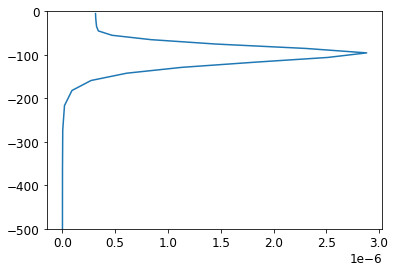

In [39]:
plt.plot((tds_diad['TChl'][36,:,30,30]),-tds_diad['deptht'])
plt.ylim([-500,0])
#plt.invert_yaxis()

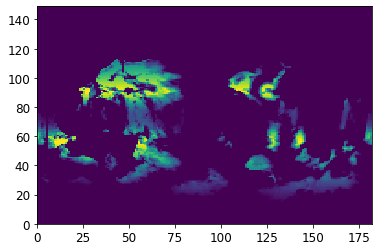

In [16]:
plt.pcolormesh(tommesh['volume'][29,:,:,0])

In [17]:
tommesh['volume']

<xarray.DataArray 'volume' (deptht: 31, y: 149, x: 182, t: 1)>
array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
...
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]]])
Dimensions without coordinates: deptht, y, x, t